In [ ]:
!pip install stardist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 10.7 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
import io


from glob import glob
from tqdm import tqdm
# from tifffile import imread
from imageio import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [ ]:
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [ ]:
X = sorted(glob('/content/drive/MyDrive/Colab Notebooks/TrainImages_Undeformed/*.png'))
Y = sorted(glob('/content/drive/MyDrive/Colab Notebooks/MaskedImages_Undeformed/*.png'))



In [ ]:
# X = list(map(imread,X)) for png
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]


<ipython-input-6-2f0a1e91f4bc> (2): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
<ipython-input-6-2f0a1e91f4bc> (3): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


In [ ]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 16/16 [00:00<00:00, 1012.60it/s]


In [ ]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  16
- training:        14
- validation:       2


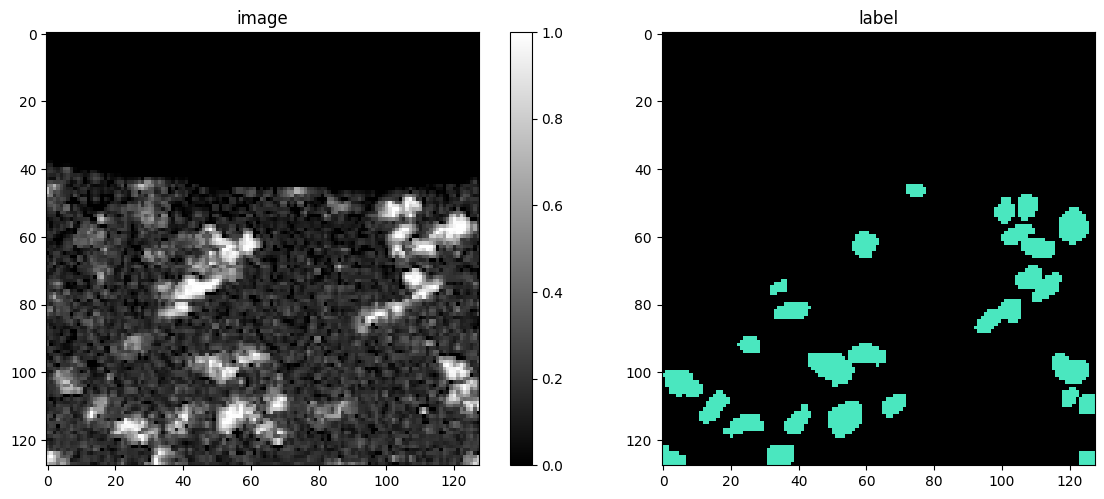

In [ ]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()


i = min(9, len(X)-1)

img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)

In [ ]:
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    train_patch_size = (128,128), # Change According to patch size
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_checkpoint='weights_best_small.h5',
    train_checkpoint_last='weights_last_small.h5',
    train_checkpoint_epoch='weights_now_small.h5'
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best_small.h5', train_checkpoint_last='weights_last_small.h5', train_checkpoint_epoch='weights_now_small.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(128, 128), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40,

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best_small.h5',
 'train_checkpoint_last': 'weights_last_small.h5',
 'train_checkpoint_epoch': 'weights_now_small.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (128, 128),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learni

In [ ]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)

In [ ]:
model = StarDist2D(conf, name='stardist_tutorial_small', basedir='/content/drive/MyDrive/Colab Notebooks/models')

base_model.py (198): output path for model already exists, files may be overwritten: /content/drive/MyDrive/Colab Notebooks/models/stardist_tutorial_small


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.373812, nms_thresh=0.3.


In [ ]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")


median object size:      [102.5 128. ]
network field of view :  [94 93]


In [ ]:
def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

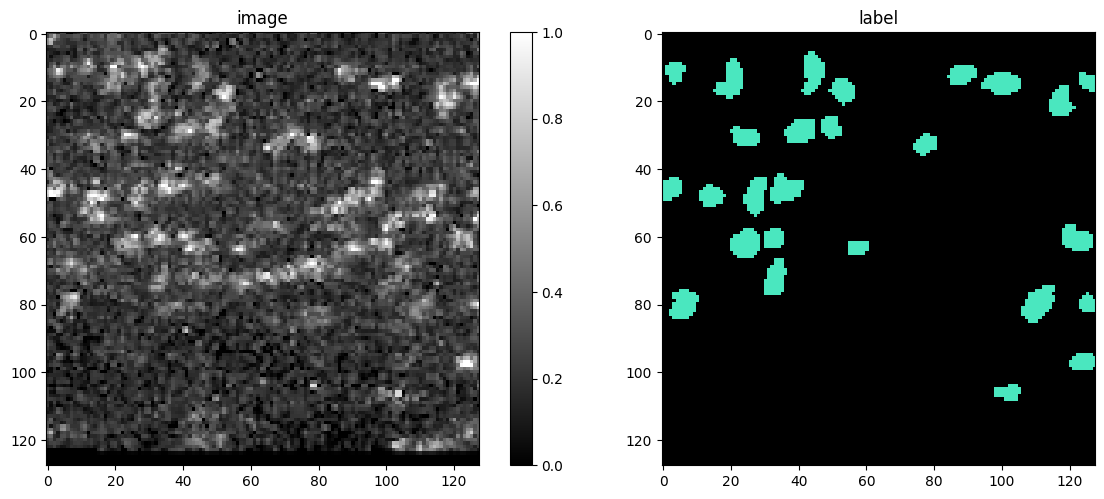

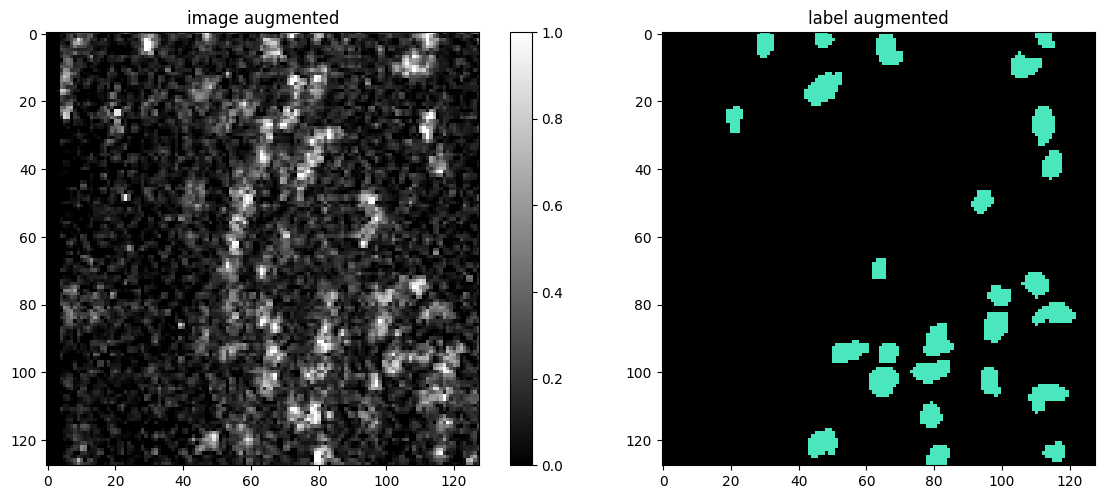

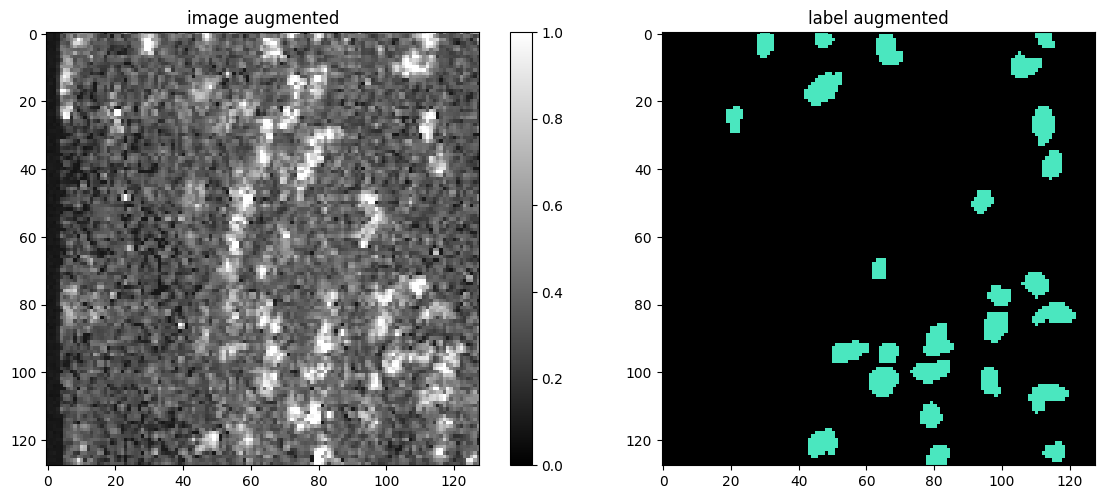

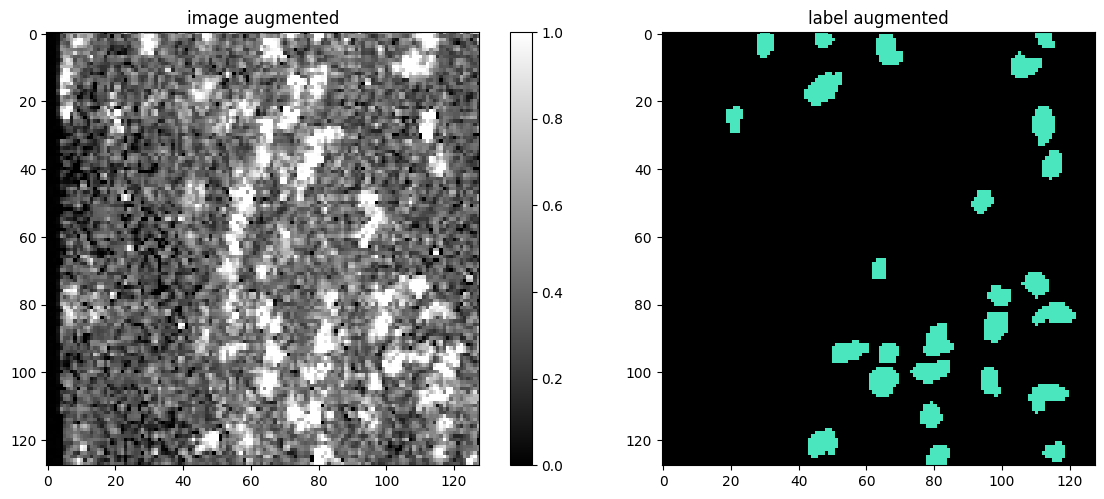

In [ ]:
img, lbl = X[1],Y[1]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=110, steps_per_epoch=100)

Epoch 1/110
100/100 [==============================] - 21s 78ms/step - loss: 0.6884 - prob_loss: 0.2219 - dist_loss: 2.3324 - prob_kld: 0.1732 - dist_relevant_mae: 2.3322 - dist_relevant_mse: 9.3666 - dist_dist_iou_metric: 0.2349 - val_loss: 0.5354 - val_prob_loss: 0.1478 - val_dist_loss: 1.9378 - val_prob_kld: 0.0967 - val_dist_relevant_mae: 1.9375 - val_dist_relevant_mse: 6.3721 - val_dist_dist_iou_metric: 0.3298 - lr: 3.0000e-04
Epoch 2/110
100/100 [==============================] - 3s 27ms/step - loss: 0.5196 - prob_loss: 0.1418 - dist_loss: 1.8890 - prob_kld: 0.0931 - dist_relevant_mae: 1.8887 - dist_relevant_mse: 6.0129 - dist_dist_iou_metric: 0.3451 - val_loss: 0.4735 - val_prob_loss: 0.1003 - val_dist_loss: 1.8662 - val_prob_kld: 0.0492 - val_dist_relevant_mae: 1.8659 - val_dist_relevant_mse: 5.8512 - val_dist_dist_iou_metric: 0.3692 - lr: 3.0000e-04
Epoch 3/110
100/100 [==============================] - 3s 31ms/step - loss: 0.4368 - prob_loss: 0.1089 - dist_loss: 1.6391 - prob

In [ ]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  15%|█▌        | 3/20 [00:00<00:00, 39.57it/s, 0.768 -> 0.000]


Using optimized values: prob_thresh=0.384205, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.38420456647872925, 'nms': 0.3}

In [ ]:
my_model = StarDist2D(None, name='stardist_tutorial_small', basedir='/content/drive/MyDrive/Colab Notebooks/models')

Loading network weights from 'weights_best_small.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.384205, nms_thresh=0.3.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model=my_model

In [ ]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


100%|██████████| 9/9 [00:00<00:00, 249.72it/s]


DatasetMatching(criterion='iou', thresh=0.5, fp=49, tp=0, fn=2, precision=0, recall=0, accuracy=0, f1=0, n_true=2, n_pred=49, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False)

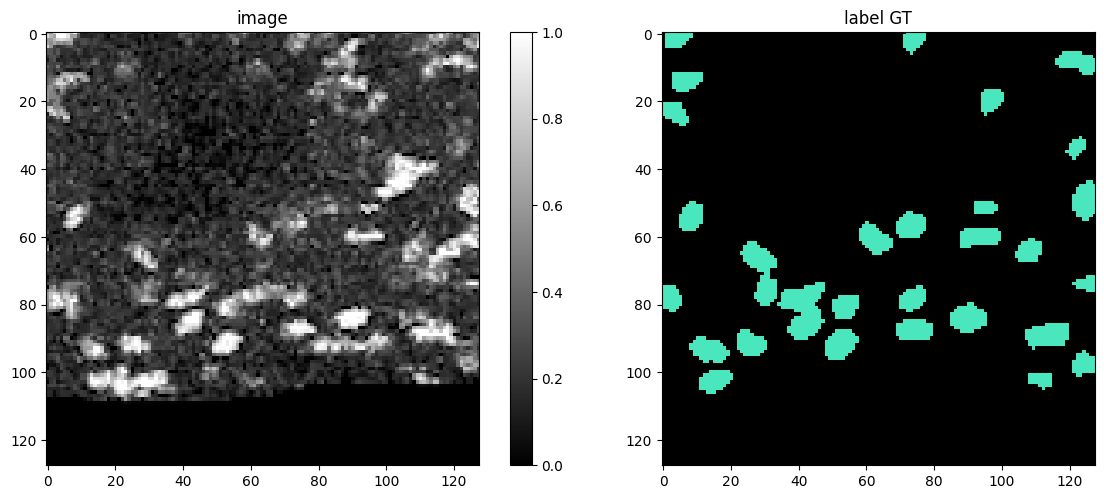

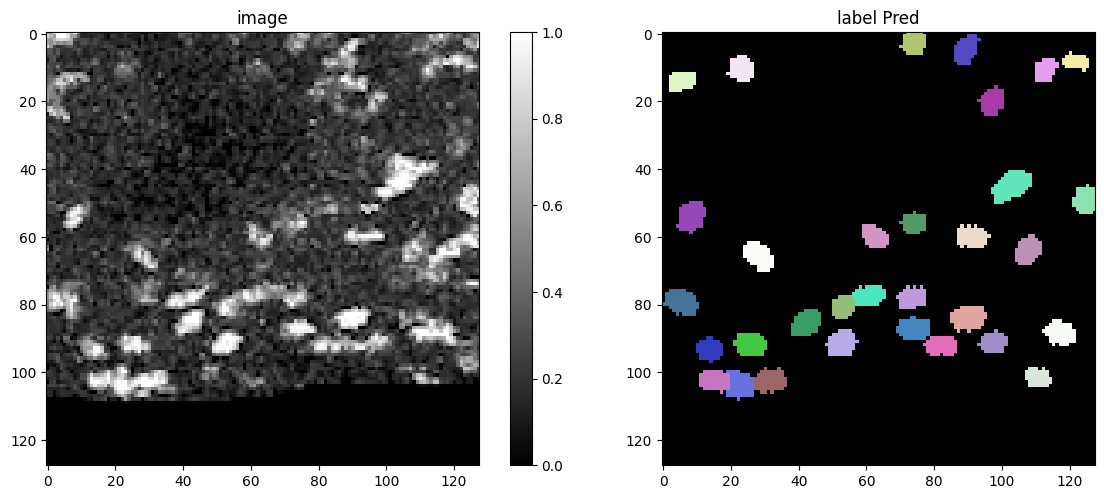

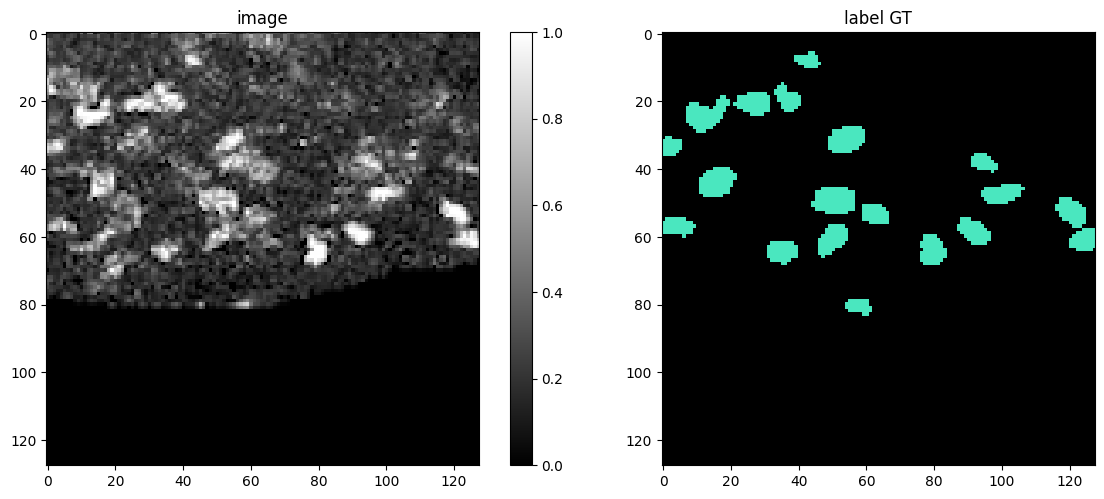

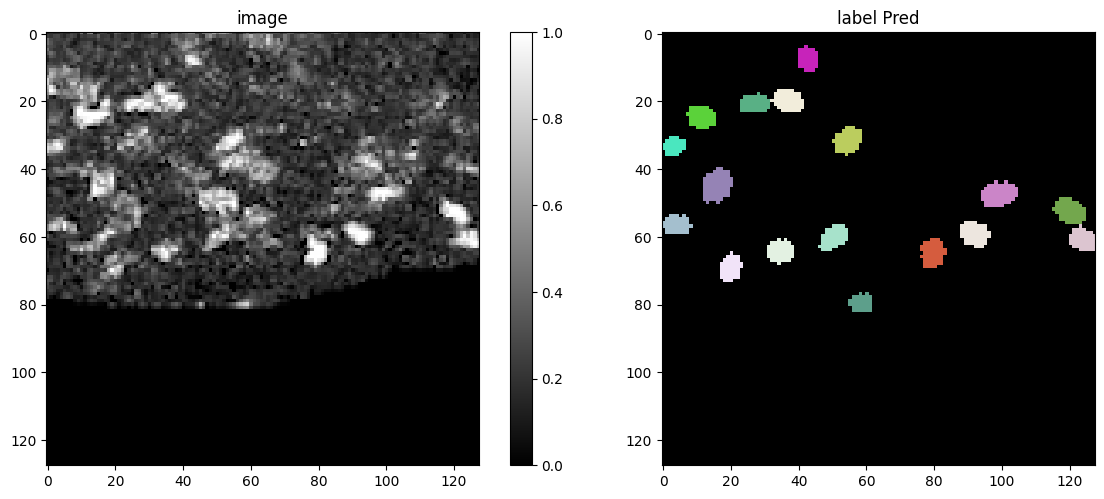

In [ ]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

plot_img_label(X_val[1],Y_val[1], lbl_title="label GT")
plot_img_label(X_val[1],Y_val_pred[1], lbl_title="label Pred")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]